In [1]:
from google.colab import drive
drive.mount("./gdrive")
!unzip "./gdrive/My Drive/Copy of A_02_5_data.zip"

Streaming output truncated to the last 5000 lines.
  inflating: content/gdrive/My Drive/A_5_data/A_05_Part_02_Dataset/Train/normal/68a9e76e-34d5-45fc-9d39-d20c2a52eaa1.png  
  inflating: content/gdrive/My Drive/A_5_data/A_05_Part_02_Dataset/Train/normal/68c02c6c-8426-4a07-ab77-7217078a6e6a.png  
  inflating: content/gdrive/My Drive/A_5_data/A_05_Part_02_Dataset/Train/normal/68c13574-a0dc-49e3-8004-923f0b2d278f.png  
  inflating: content/gdrive/My Drive/A_5_data/A_05_Part_02_Dataset/Train/normal/68c36cca-65a3-451b-9e47-4fda245588bc.png  
  inflating: content/gdrive/My Drive/A_5_data/A_05_Part_02_Dataset/Train/normal/68c51c0c-777a-4e8a-9543-7f6a6101e6c9.png  
  inflating: content/gdrive/My Drive/A_5_data/A_05_Part_02_Dataset/Train/normal/68c87e83-8ab6-412a-b0bb-25b4e1d1e678.png  
  inflating: content/gdrive/My Drive/A_5_data/A_05_Part_02_Dataset/Train/normal/68cad8ac-5e8e-45d8-ab2f-8a119580087d.png  
  inflating: content/gdrive/My Drive/A_5_data/A_05_Part_02_Dataset/Train/normal/68d6f135

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm
from sklearn.metrics import *
import pandas as pd
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.Resize(256),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder('/content/content/gdrive/My Drive/A_5_data/A_05_Part_02_Dataset/Train', transform=train_transforms)
validation_data = datasets.ImageFolder('/content/content/gdrive/My Drive/A_5_data/A_05_Part_02_Dataset/Validation', transform=train_transforms)
test_data = datasets.ImageFolder('/content/content/gdrive/My Drive/A_5_data/A_05_Part_02_Dataset/Test', transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=200, shuffle=True,num_workers=5)

validationloader = torch.utils.data.DataLoader(validation_data, batch_size=200, shuffle=True,num_workers=5)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['covid-19', 'normal', 'pneumonia']


Training images with augmentation


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


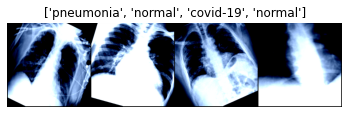

Testing images without augmentation


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


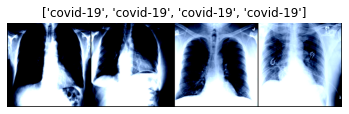

In [4]:
# Creating function to show images
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# creating grid to display batch of images 
def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
print('Training images with augmentation')
inputs, classes = next(iter(trainloader))
# displaying training images
show_databatch(inputs[:4], classes[:4])

# Get a batch of testing data
print('Testing images without augmentation')
inputs, classes = next(iter(testloader))
# displaying testing images
show_databatch(inputs[:4], classes[:4])

In [0]:
# creating a function to train training data in differement experiments using different structures and models 
def train_model(model, epochs, training_data, validation_data, optimizer, criterion, filename):
    # Converting data to GPU processable form if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()
    # creating arrays to store stats
    training_accuracy = []
    validation_accuracy = []
    training_loss = []
    validation_loss = []
    nb_digits = 3 
    # Traing data
    for epoch in range(epochs):  # loop over the dataset multiple times
        # to show progress 
        pbar = tqdm(enumerate(training_data))
        
        # getting each batch for training 
        for i, data in pbar:
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            label_onehot = torch.FloatTensor(len(labels), nb_digits)
            label_onehot=label_onehot.to(device)
            label_onehot.zero_()
            label_onehot.scatter_(1, labels.data.unsqueeze(dim=1), 1)            
            # zero the parameter gradients
            optimizer.zero_grad()
            # feedforward
            outputs = model(inputs)
            # computing loss              
            loss = criterion(outputs, label_onehot)
            # backprpagation   
            loss.backward() 
            # updating weights                    
            optimizer.step()                    

            # displaying progess
            pbar.set_description(
                'Training Epoch: {},({:.0f}%)'.format(
                    epoch+1, int((100. * i / len(training_data))+1)))
        
        # Displaying stats for current epoch
        # calculating stats on training data for current epoch
        print('\nFor training data')
        train_loss,train_accu,train_precision,train_recall,train_f1,train_confusion = scores(training_data,model)

        # calculating stats on validation data for current epoch
        print('\nFor validation data')
        valid_loss,valid_accu,valid_precision,valid_recall,valid_f1,valid_confusion = scores(validation_data,model)
        
        # storing stats in arrays to plot curves
        training_accuracy.append(train_accu)
        validation_accuracy.append(valid_accu)
        training_loss.append(train_loss)
        validation_loss.append(valid_loss)
        print("\nTraining Accuracy = ",train_accu, '\nTraining Loss = ',train_loss, "\nValidation Accuracy = ",valid_accu, '\nValidation Loss = ',valid_loss,"\n")  
    
    # displaing final epoch's stats on training data
    print('Final Stats:\n')
    train_stats = pd.DataFrame([train_loss,train_accu,train_precision,train_recall,train_f1],['Loss','Accuracy','Precision','Recall','F1_Score'],['Training Scores']).T
    print(train_stats)
    print()
    
    # displaing final epoch's stats on validaiton data
    valid_stats = pd.DataFrame([valid_loss,valid_accu,valid_precision,valid_recall,valid_f1],['Loss','Accuracy','Precision','Recall','F1_Score'],['Validation Scores']).T
    print(valid_stats)
    print()

    # displaying confusion matrix for training data
    sns.heatmap(train_confusion, annot=True, fmt='g', cbar=False, cmap=['Pink','Grey','Red','Green'])
    plt.title('Confusion Matrix for Training Data')
    plt.xlim(reversed(plt.xlim()))
    plt.show()
    print()

    # displaying confusion matrix for validation data
    sns.heatmap(valid_confusion, annot=True, fmt='g', cbar=False, cmap=['Pink','Grey','Red','Green'])
    plt.title('Confusion Matrix for Validation Data')
    plt.xlim(reversed(plt.xlim()))
    plt.show()
    print()

    # plotting entropy loss on training and validation data
    plt.title('Loss')
    plt.plot(range(epochs),training_loss, label= 'Training Data')
    plt.plot(range(epochs),validation_loss,label='Validation Data')
    plt.ylim(0,1)
    plt.legend()
    plt.show()  
    print()
        
    # plotting accuracy for training and validation data
    plt.title('Accuracy')
    plt.plot(range(epochs),training_accuracy,label= 'Training Data')
    plt.plot(range(epochs),validation_accuracy,label= 'Validation Data')
    plt.ylim(70,100)
    plt.legend()
    plt.show()
    
    # saving the model
    torch.save(model.state_dict(), filename)

In [0]:
def scores(dataset,model):
    correct = 0
    total = 0
    loss = 0
    predicted = []
    true_labels = []
    nb_digits = 3 
    # getting prediction made by the model     
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    with torch.no_grad():
        # to display progess
        pbar = tqdm(enumerate(dataset))
        # getting each batch 
        for i,data in pbar:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            val_label_onehot=torch.FloatTensor(len(labels), nb_digits)
            val_label_onehot=val_label_onehot.to(device)
            val_label_onehot.zero_()
            val_label_onehot.scatter_(1,labels.data.unsqueeze(dim=1),1.0)  
            # Feedforward
            outputs = model(images)
            # calculating predictions by the model
            _, pred = torch.max(outputs.data, 1)
            # storing predictions in a list 
            predicted.extend(pred.tolist())
            # storing actutal labels in list
            true_labels.extend(labels.tolist())            
            # calculating loss 
            loss += criterion(outputs, val_label_onehot).item()

            # displaying progress
            pbar.set_description(
                'Calculating Accuracy and Loss: ({:.0f}%)'.format(
                    int((100. * i / len(dataset))+1)))
    
    # calculating loss on whole data
    total_loss = loss/len(dataset)
    # calculating accurate predictions of model on whole data
    accuracy = accuracy_score(true_labels,predicted)*100
    # calculating recall
    recall = recall_score(true_labels,predicted,average='micro')*100
    # calculating precision
    precision = precision_score(true_labels,predicted,average='micro')*100
    # calculating F1_Score
    f1 = f1_score(true_labels,predicted,average='micro')*100
    # making confusion matrix
    confusion = pd.DataFrame(confusion_matrix(true_labels,predicted),['covid-19','pneumonia','Normal'],['covid-19','pneumonia','Normal'])

    return total_loss,accuracy,precision,recall,f1,confusion

In [0]:
def GenerateCSV(dataset,model):
    correct = 0
    total = 0
    loss = 0
    predicted = []
    true_labels = []
    nb_digits = 3 
    f = open("WithOutFocalVgg", "w")
    # getting prediction made by the model 
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    with torch.no_grad():
        # to display progess
        # = tqdm(enumerate(dataset))
        # getting each batch 
        for i, data in enumerate(dataset, 0):
            images, labels = data            
            images, labels = images.to(device), labels.to(device)
            val_label_onehot=torch.FloatTensor(len(labels), nb_digits)
            val_label_onehot=val_label_onehot.to(device)
            val_label_onehot.zero_()
            val_label_onehot.scatter_(1,labels.data.unsqueeze(dim=1),1.0)  
            # Feedforward
            outputs = model(images)            
            #print(outputs)
            # calculating predictions by the model  
            test = torch.sigmoid(outputs)          
            #_, pred = torch.sigmoid(outputs)
            # storing predictions in a list 
            #print(test)
            #predicted.extend(test.tolist())            
            imageName = dataset.dataset.samples[i][0].split("/")[-1]     
            #print("imageName",type(imageName))
            listof = test.tolist()  
            #withname = listof.append(imageName)   
            #listof += [imageName]   
            #print(listof)
            if(listof[0][0]>0.5):
              listof[0][0] = 1
            else:
              listof[0][0] = 0

            if(listof[0][2]>0.5):
              listof[0][2] = 1
            else:
              listof[0][2] = 0

            if(listof[0][1]>0.5):
              listof[0][1] = 1
            else:
              listof[0][1] = 0
            f.write("{},{},{},{}\n".format(imageName,listof[0][0],listof[0][2],listof[0][1] ))
            #predicted.extend(.insert(0,imageName))
            # storing actutal labels in list
            #true_labels.extend(labels.tolist())            
            # calculating loss 

            #loss += criterion(outputs, val_label_onehot).item()

            # displaying progress
            #pbar.set_description(
            #    'Calculating Accuracy and Loss: ({:.0f}%)'.format(
            #        int((100. * i / len(dataset))+1)))
    
    # calculating loss on whole data
    #total_loss = loss/len(dataset)
    print(predicted);
    # calculating accurate predictions of model on whole data
    #accuracy = accuracy_score(true_labels,predicted)*100
    # calculating recall
    #recall = recall_score(true_labels,predicted,average='micro')*100
    # calculating precision
    #precision = precision_score(true_labels,predicted,average='micro')*100
    # calculating F1_Score
    #f1 = f1_score(true_labels,predicted,average='micro')*100
    # making confusion matrix
    #confusion = pd.DataFrame(confusion_matrix(true_labels,predicted),['covid-19','pneumonia','Normal'],['covid-19','pneumonia','Normal'])
    f.close()
    return 1

In [7]:
vgg16 = models.vgg16(pretrained=True)
features = []
num_features = 87*10+100
num_classes = 3
features.extend([nn.Linear(25088, num_features)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout()])
features.extend([nn.Linear(num_features, num_classes)])
vgg16.classifier = nn.Sequential(*features)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [0]:
i = 0
for param in vgg16.features.parameters():
    i=i+1
    if i > 16:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [9]:
print('Following Parameters/Features are freezed:')
for name, param in vgg16.named_parameters():
    if param.requires_grad==False:
        print(name)
print('\nFollowing Parameters/Features will be trained:')
for name, param in vgg16.named_parameters():
    if param.requires_grad==True:
        print(name)

Following Parameters/Features are freezed:
features.0.weight
features.0.bias
features.2.weight
features.2.bias
features.5.weight
features.5.bias
features.7.weight
features.7.bias
features.10.weight
features.10.bias
features.12.weight
features.12.bias
features.14.weight
features.14.bias
features.17.weight
features.17.bias

Following Parameters/Features will be trained:
features.19.weight
features.19.bias
features.21.weight
features.21.bias
features.24.weight
features.24.bias
features.26.weight
features.26.bias
features.28.weight
features.28.bias
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias


In [0]:
#torch.cuda.empty_cache()

Training Epoch: 1,(97%): : 31it [02:12,  4.28s/it]


For training data



Calculating Accuracy and Loss: (97%): : 31it [02:09,  4.16s/it]



For validation data


Calculating Accuracy and Loss: (76%): : 4it [00:14,  3.50s/it]



Training Accuracy =  71.85483870967741 
Training Loss =  0.42328763200390723 
Validation Accuracy =  71.97452229299363 
Validation Loss =  0.4279126226902008 



Training Epoch: 2,(97%): : 31it [02:07,  4.12s/it]


For training data



Calculating Accuracy and Loss: (97%): : 31it [02:11,  4.24s/it]


For validation data



Calculating Accuracy and Loss: (76%): : 4it [00:14,  3.73s/it]



Training Accuracy =  80.19354838709677 
Training Loss =  0.34782825073888224 
Validation Accuracy =  78.343949044586 
Validation Loss =  0.3554699048399925 



Training Epoch: 3,(97%): : 31it [02:10,  4.20s/it]


For training data



Calculating Accuracy and Loss: (97%): : 31it [02:10,  4.20s/it]


For validation data



Calculating Accuracy and Loss: (76%): : 4it [00:14,  3.59s/it]



Training Accuracy =  82.2258064516129 
Training Loss =  0.30115178804243764 
Validation Accuracy =  82.80254777070064 
Validation Loss =  0.3258770927786827 



Training Epoch: 4,(97%): : 31it [02:10,  4.20s/it]


For training data



Calculating Accuracy and Loss: (97%): : 31it [02:10,  4.22s/it]


For validation data



Calculating Accuracy and Loss: (76%): : 4it [00:13,  3.48s/it]



Training Accuracy =  84.0 
Training Loss =  0.28431925321778945 
Validation Accuracy =  83.7579617834395 
Validation Loss =  0.2742500863969326 



Training Epoch: 5,(97%): : 31it [02:11,  4.25s/it]


For training data



Calculating Accuracy and Loss: (97%): : 31it [02:13,  4.31s/it]


For validation data



Calculating Accuracy and Loss: (76%): : 4it [00:14,  3.54s/it]



Training Accuracy =  84.85483870967741 
Training Loss =  0.265128418803215 
Validation Accuracy =  84.71337579617835 
Validation Loss =  0.28181490674614906 

Final Stats:

                     Loss   Accuracy  Precision     Recall   F1_Score
Training Scores  0.265128  84.854839  84.854839  84.854839  84.854839

                       Loss   Accuracy  Precision     Recall   F1_Score
Validation Scores  0.281815  84.713376  84.713376  84.713376  84.713376



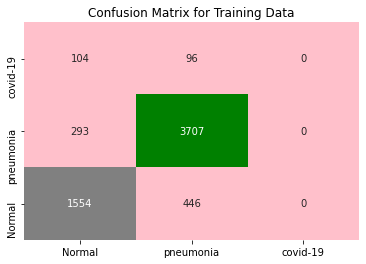

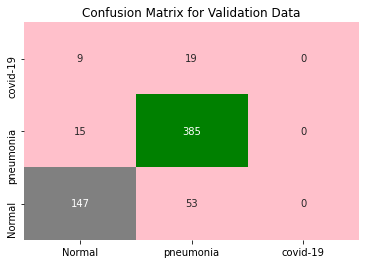

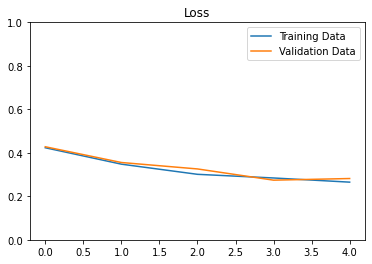

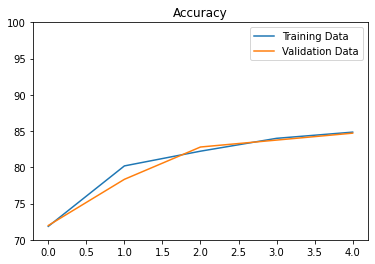

In [10]:
Epochs = 5
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
filename = 'vgg16_Assignment5B.pth'
train_model(vgg16, Epochs,trainloader, validationloader, optimizer, criterion, filename)

In [86]:
testloader = torch.utils.data.DataLoader(test_data)
GenerateCSV(testloader,vgg16)

[]


1